In [1]:
from k1lib.imports import *

In [2]:
class Network(nn.Module):
    def __init__(self, hiddenDim=10, hiddenLayers=2, relu=True):
        super().__init__()
        activation = lambda: nn.LeakyReLU() if relu else nn.Sigmoid()
        layers = []
        layers += [nn.Linear(1, hiddenDim), activation()]
        for i in range(hiddenLayers):
            layers += [nn.Linear(hiddenDim, hiddenDim), activation()]
        layers += [nn.Linear(hiddenDim, 1)]
        self.bulk = nn.Sequential(*layers)
    def forward(self, x):
        return self.bulk(x)

In [25]:
def newL(bs=64, optF=None, hiddenLayers=2, simple=False):
    if optF == None: optF = lambda x: optim.SGD(x, lr=2e-4, momentum=0.9)
    if optF == "Adam": optF = lambda p: optim.Adam(p, lr=1e-2)
    l = k1lib.Learner()
    l.model = Network(hiddenLayers=hiddenLayers)
    l.data = k1lib.data.Data.fromDataset(k1lib.data.FunctionDataset.exp, bs)
    l.opt = optF(l.model.parameters())
    l.lossF = lambda x, y: ((x.squeeze() - y)**2).mean()
    #l.lossF = lambda x, y: (x**2).mean()
    if simple: l.cbs = k1lib.Callbacks().withProgressBar()
    l.cbs.withModifyBatch(lambda x, y: (x[:, None], y))
    l.cbs.withDType(torch.float32);
    def evaluate(self):
        xbs, ybs, ys = self.record(1, 3)
        xbs = torch.vstack(xbs).squeeze()
        ybs = torch.vstack([yb[:, None] for yb in ybs]).squeeze()
        ys = torch.vstack(ys).squeeze()
        #plt.plot(xbs, ybs, ".")
        plt.plot(xbs, ys.detach(), ".")
    l.evaluate = partial(evaluate, l)
    #l.cbs.withCancelOnLowLoss(1, epochMode=True)
    return l

In [15]:
hs = range(100)
elapsedTimes = []
for h in range(100):
    l = newL(optF="Adam", hiddenLayers=h, simple=False)
    l.remove("Autosave")
    l.run(1);
    elapsedTimes.append(l.elapsedTime)
with open("complex.pth", "wb") as f: pickle.dump(k1lib.Object.fromDict({"hs": hs, "elapsedTimes": elapsedTimes}), f)

Progress:  74%, epoch: 0/1, batch:   23/31, elapsed:    6.8s  

In [26]:
hs = range(100)
elapsedTimes = []
for h in range(100):
    l = newL(optF="Adam", hiddenLayers=h, simple=True)
    l.run(1);
    elapsedTimes.append(l.elapsedTime)
with open("simple.pth", "wb") as f: pickle.dump(k1lib.Object.fromDict({"hs": hs, "elapsedTimes": elapsedTimes}), f)

Progress:  74%, epoch: 0/1, batch:   23/31, elapsed:   2.74s  

## Analysis

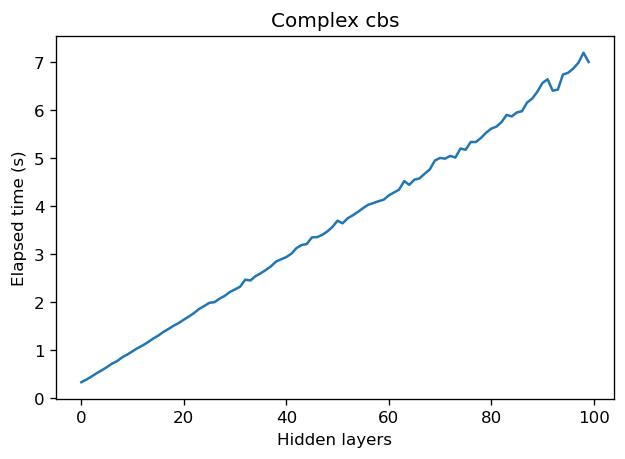

In [27]:
with open("complex.pth", "rb") as f: data = pickle.load(f)
plt.figure(dpi=120); plt.xlabel("Hidden layers"); plt.ylabel("Elapsed time (s)"); plt.title("Complex cbs")
plt.plot(data.hs, data.elapsedTimes);

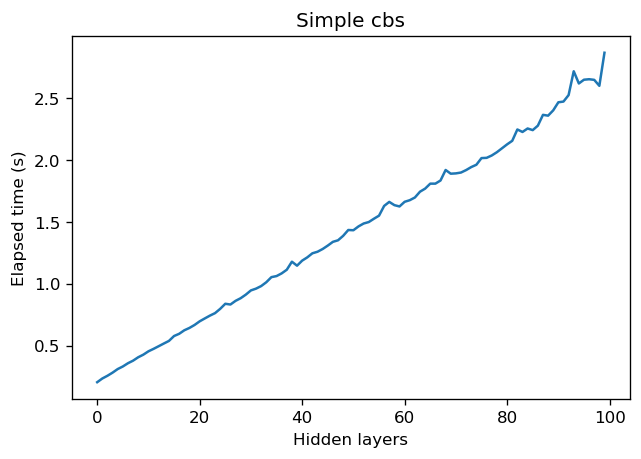

In [28]:
with open("simple.pth", "rb") as f: data = pickle.load(f)
plt.figure(dpi=120); plt.xlabel("Hidden layers"); plt.ylabel("Elapsed time (s)"); plt.title("Simple cbs")
plt.plot(data.hs, data.elapsedTimes);

Yeah pretty linear, no surprises there, but just to be sure. Also the hooks do weigh things down a lot, so don't use it/use selectively on really long runs